In [204]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from datetime import timedelta, timezone, datetime
from typing import *
from pandas import Series, DataFrame

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
train_path = os.path.join(data_dir, 'train_data.csv')
test_path = os.path.join(data_dir, 'test_data.csv')
u_train_path = os.path.join(data_dir, 'upgraded_df.csv')
submission_path = os.path.join(data_dir, 'sample_submission.csv')

In [148]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
u_train_df = pd.read_csv(u_train_path)

In [ ]:
# df.groupby('userID')['answerCode'].agg(['mean']).describe()
# # df_test.groupby('userID')['assessmentItemID'].agg(['count']).describe()
# df_train_ori.groupby('userID')['answerCode'].agg(['mean']).describe()

### 풀이 시간 time_diff

In [4]:
def create_diff_time(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1).fillna(pd.Timedelta(seconds=37))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

    df['time'] = diff
    # # 아웃라이어를 보정
    df['time'] = df['time'].apply(lambda x: x if x < 350 else 37)     
    
    return df

In [9]:
train_df = create_diff_time(train_df)
test_df = create_diff_time(test_df)

AxesSubplot(0.125,0.125;0.775x0.755)
67.0


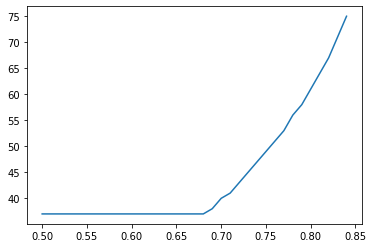

In [10]:
print(train_df['time'].quantile([0.5 +(0.01 * i) for i in range(35)]).plot())
print(train_df['time'].quantile(0.82))

AxesSubplot(0.125,0.125;0.775x0.755)
67.0


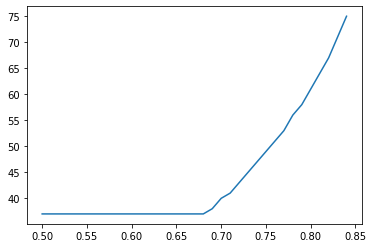

In [11]:
print(test_df['time'].quantile([0.5 +(0.01 * i) for i in range(35)]).plot())
print(test_df['time'].quantile(0.82))

In [15]:
train_df['time'].describe()

count    2.266586e+06
mean     4.583185e+01
std      5.420090e+01
min      0.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      4.900000e+01
max      3.490000e+02
Name: time, dtype: float64

In [17]:
test_df['time']

0         26.0
1         94.0
2          5.0
3          7.0
4          3.0
          ... 
260109    18.0
260110    21.0
260111    89.0
260112    32.0
260113    37.0
Name: time, Length: 260114, dtype: float64

### grade

In [8]:
def get_grade(df:DataFrame) -> Series:
    g = df['testId'].apply(lambda row: int(row[2]))
    return g

In [10]:
train_df['grade'] = get_grade(train_df)

In [11]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4


### 누적 정답수, 정답률

In [55]:
def create_cum_ans(df):
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['user_acc'].fillna(0.65, inplace=True)
    return df

In [56]:
train_df = create_cum_ans(train_df)

In [61]:
train_df.groupby(['userID'])['answerCode'].agg('count').quantile(0.75)


513.0

### 추천시스템을 이용한 feature 생성

In [62]:
from surprise import Reader, Dataset, Trainset
from surprise import SVD, SVDpp, NMF, KNNBaseline, KNNBasic
from surprise.model_selection import train_test_split, cross_validate

In [63]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0,0.650000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000
...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,4,0.250000
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,5,0.200000
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2.0,6,0.333333
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3.0,7,0.428571


In [75]:
def feature_split_user(df, is_train):
        if is_train:
            # UserID를 시험지로 나눔
            arr = []
            for ele in df.assessmentItemID.values:
                arr.append(ele[:3])
            newID = [str(e1) + str(e2) for e1, e2 in zip(arr, df["userID"])]
            df["userID"] = newID
        else:
            temp = df.copy()
            # UserID를 시험지로 나눔
            grade_arr = []
            for ele in temp.assessmentItemID.values:
                grade_arr.append(ele[:3])

            newID = [str(e1) + str(e2) for e1, e2 in zip(grade_arr, temp["userID"])]
            temp["userID"] = newID

            test_data = temp[temp['answerCode'] == -1]
            bool_arr = []

            for id in temp['userID']:
                if id in test_data['userID'].values:
                    bool_arr.append(True)
                else:
                    bool_arr.append(False)

            df = df[bool_arr]

        return df

In [149]:
train_df1 = feature_split_user(train_df, True)

In [150]:
train_df1['grade'] = get_grade(train_df1)
train_df1 = train_df1[train_df1['grade'] == 1]

In [151]:
train_df1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
2150,A015,A010018001,A010000018,1,2020-05-09 12:10:41,5485,1
2151,A015,A010018002,A010000018,1,2020-05-09 12:11:35,5485,1
2152,A015,A010018003,A010000018,1,2020-05-09 12:12:09,5485,1
2153,A015,A010018004,A010000018,1,2020-05-09 12:12:39,5485,1
2154,A015,A010018005,A010000018,1,2020-05-09 12:13:27,5485,1
...,...,...,...,...,...,...,...
2266485,A017434,A010068001,A010000068,1,2020-07-14 12:09:55,6456,1
2266486,A017434,A010068002,A010000068,0,2020-07-14 12:10:17,6456,1
2266487,A017434,A010068003,A010000068,0,2020-07-14 12:10:33,6456,1
2266488,A017434,A010068005,A010000068,0,2020-07-14 12:11:18,6456,1


In [152]:
ans_df = train_df1[train_df1['userID'] != train_df1['userID'].shift(-1)].copy()
# print(ans_df)
# train_df1.loc[train_df1['userID'] != train_df1['userID'].shift(-1), 'answerCode'] = 
# que_df = train_df1
# que_df.isnull().sum()

In [155]:
que_df = train_df1.loc[train_df1['userID'] == train_df1['userID'].shift(-1)]
que_df.isnull().sum()
que_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
2150,A015,A010018001,A010000018,1,2020-05-09 12:10:41,5485,1
2151,A015,A010018002,A010000018,1,2020-05-09 12:11:35,5485,1
2152,A015,A010018003,A010000018,1,2020-05-09 12:12:09,5485,1
2153,A015,A010018004,A010000018,1,2020-05-09 12:12:39,5485,1
2154,A015,A010018005,A010000018,1,2020-05-09 12:13:27,5485,1
...,...,...,...,...,...,...,...
2266461,A017432,A010191004,A010000191,0,2020-09-25 01:02:09,7815,1
2266485,A017434,A010068001,A010000068,1,2020-07-14 12:09:55,6456,1
2266486,A017434,A010068002,A010000068,0,2020-07-14 12:10:17,6456,1
2266487,A017434,A010068003,A010000068,0,2020-07-14 12:10:33,6456,1


In [156]:
def prep_surprise_dataset(df):
    # surprise에서 사용가능하도록  데이터셋 처리
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df((df[['userID', 'assessmentItemID', 'answerCode']]), reader=reader)
    
    # train, test = train_test_split(data, test_size=0.25, random_state=42)   
    # 데이터셋 전체를 학습데이터로 사용할 때
    train = data.build_full_trainset()
    test = Trainset.build_testset(train)
    return data, train, test

In [157]:
data, train, test = prep_surprise_dataset(que_df)

In [185]:
def train_model(model, data, train, test):

    algo = model(n_factors=64, n_epochs=20, random_state=42)
    cross_validate(algo, data, measures=['rmse', 'mae'], cv=5, verbose=True)
    algo.fit(train)

    return algo

In [186]:
algo = train_model(SVD, data, train, test)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.3586  0.3565  0.3565  0.3595  0.3561  0.3609  0.3576  0.3561  0.3563  0.3584  0.3576  0.0016  
MAE (testset)     0.2591  0.2552  0.2559  0.2580  0.2552  0.2608  0.2572  0.2559  0.2564  0.2585  0.2572  0.0018  
Fit time          17.29   16.64   16.30   16.55   17.24   17.60   17.06   17.09   16.91   16.47   16.92   0.39    
Test time         0.23    0.21    0.86    0.21    0.24    0.85    0.24    0.23    0.82    0.23    0.41    0.28    


In [203]:
algo2 = train_model(NMF, data, train, test)

ZeroDivisionError: float division

In [160]:
ans_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
2611,A015,A010154004,A010000154,0,2020-10-26 11:49:28,7803,1
5025,A018,A010095005,A010000095,0,2020-10-22 11:19:03,7626,1
8498,A0114,A010154004,A010000154,1,2020-10-26 10:11:45,7803,1
10953,A0116,A010163005,A010000163,1,2020-10-25 04:10:28,7809,1
11777,A0118,A010155005,A010000155,0,2020-10-26 06:42:02,7804,1
...,...,...,...,...,...,...,...
2266170,A017413,A010192005,A010000192,1,2020-10-15 11:35:09,7075,1
2266193,A017415,A010142005,A010000142,0,2020-09-29 12:41:25,7801,1
2266220,A017419,A010093005,A010000093,0,2020-05-25 03:08:54,6557,1
2266462,A017432,A010191005,A010000191,1,2020-09-25 01:02:21,7815,1


In [173]:
print(algo.predict('A017434', 'A010068004')[3])

0.39328312362579076


In [202]:
cnt = 0
for i, row in ans_df.iterrows():
    pred = 1 if algo.predict(row['userID'], row['assessmentItemID'])[3] > 0.51 else 0
    if pred == row['answerCode']:
        cnt += 1
    
print(cnt/2074)

0.740115718418515


### validation 전략

In [317]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.sort_values(by=['userID','Timestamp'], inplace=True) 
df_test.sort_values(by=['userID','Timestamp'], inplace=True)

In [318]:
def feature_split_user(df, is_train):
        if is_train:
            # UserID를 시험지로 나눔
            arr = []
            for ele in df.assessmentItemID.values:
                arr.append(ele[:3])
            newID = [str(e1) + str(e2) for e1, e2 in zip(arr, df["userID"])]
            df["userID"] = newID
        else:
            temp = df.copy()
            # UserID를 시험지로 나눔
            grade_arr = []
            for ele in temp.assessmentItemID.values:
                grade_arr.append(ele[:3])

            newID = [str(e1) + str(e2) for e1, e2 in zip(grade_arr, temp["userID"])]
            temp["userID"] = newID

            test_data = temp[temp['answerCode'] == -1]
            bool_arr = []

            for id in temp['userID']:
                if id in test_data['userID'].values:
                    bool_arr.append(True)
                else:
                    bool_arr.append(False)

            df = df[bool_arr]

        return df

In [319]:
new_df_train = feature_split_user(df_train, is_train=True)
new_df_test = feature_split_user(df_test, is_train=True)
new_df_train.sort_values(by=['userID','Timestamp'], inplace=True) 
new_df_test.sort_values(by=['userID','Timestamp'], inplace=True) 

In [320]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test.loc[df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID
new_set_assessmentItemID = set(new_df_test.loc[new_df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID

- 맞춰야할 문항ID의 종류는 444개

In [321]:
print(len(set_assessmentItemID))
print(len(new_set_assessmentItemID))

444
444


In [331]:
def split_text_oritented_validset(df):

    val_userids = df[(df['userID'] != df['userID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]['userID']
#     return val_userids
    return df[df.userID.isin(val_userids)]

In [333]:
tmp = split_text_oritented_validset(new_df_train)

In [337]:
len(set(tmp['userID']))

9396

In [341]:
len(new_train_df['userID'].unique())

17752

In [350]:
len(tmp[(tmp['userID'] != tmp['userID'].shift(-1))]['assessmentItemID'].unique())

426

In [351]:
tmp.shift(-1)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
76540,A01100,A010007002,A010000007,1.0,2020-03-03 06:36:01,5814.0
76541,A01100,A010007003,A010000007,0.0,2020-03-03 06:36:29,5814.0
76542,A01100,A010007004,A010000007,0.0,2020-03-03 06:38:24,5814.0
76543,A01100,A010007005,A010000007,0.0,2020-03-03 06:39:00,5814.0
76544,A01100,A010011001,A010000011,1.0,2020-03-10 05:54:45,7581.0
...,...,...,...,...,...,...
686583,A09987,A090061005,A090000061,1.0,2020-10-16 21:47:20,9927.0
686584,A09987,A090061006,A090000061,0.0,2020-10-16 21:47:23,2605.0
686585,A09987,A090061007,A090000061,1.0,2020-10-16 21:47:24,2608.0
686586,A09987,A090061008,A090000061,1.0,2020-10-16 21:47:27,9927.0


In [ ]:
# preprocess.load_test_data(args.test_file_name, train_df=args.file_name)
# test_data = preprocess.get_test_data()
# set_assessmentItemID = set(test_data.loc[test_data.answerCode == -1, 'assessmentItemID'].values)
# val_userids = set(data[(data['userID'] != data['userID'].shift(-1)) & (data.assessmentItemID.isin(set_assessmentItemID))]['userID'])
# random.seed(args.seed)
# random.shuffle(val_userids)
# train_data = data[data.userID.isin(val_userids[:len(val_userids)//2])]
# valid_data = data[not data.userID.isin(val_userids[:len(val_userids)//2])]